# Resting EEG Data

This notebook ....

## Dataset Details

Words, words, words.

In [1]:
import os
from pathlib import Path

import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt

from antropy import app_entropy

from fooof import FOOOF
from fooof.utils import trim_spectrum

from neurodsp.utils import create_times
from neurodsp.spectral import compute_spectrum
from neurodsp.plts import plot_time_series, plot_power_spectra

from bootstrap import bootstrap_corr

/var/folders/59/8y2d5r257c77vzymnqs47x080000gn/T/ipykernel_59428/4025414407.py:10: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  from fooof import FOOOF


In [2]:
# Import custom code
import sys
sys.path.append(str(Path('..').resolve()))

from apm.run import run_measures
from apm.plts import plot_dots
from apm.utils import format_corr
from apm.methods import specparam, lempelziv, hjorth_complexity, dfa, hurst, irasa

## Settings

In [3]:
# Define the data folder
folder = Path('/Users/tom/Data/VoytekLab/ExtractedSubsets/eeg_data')

In [4]:
# Define data field to extract from files
data_field = 'oz_rest_data'

In [5]:
# Get the list of available files
files = os.listdir(folder)
files = sorted([file for file in files if file.split('.')[-1] == 'mat'])

In [6]:
# FIX: temporarily drop subject which has a data quirk (wrong size array)
files = [file for file in files if '1009' not in file]

In [7]:
# Check the number of subjects
n_subjs = len(files)
print('Number of subjects: {}'.format(n_subjs))

Number of subjects: 28


In [8]:
# Define data information
fs = 500
n_seconds = 120

In [9]:
# Define times vector for data
times = create_times(n_seconds, fs)

## Load Data


In [10]:
# Collect and load all data segments
data = []
for file in files:
    loaded = loadmat(folder / file, squeeze_me=True)
    data.append(loaded[data_field])
data = np.array(data)

## Data Checks

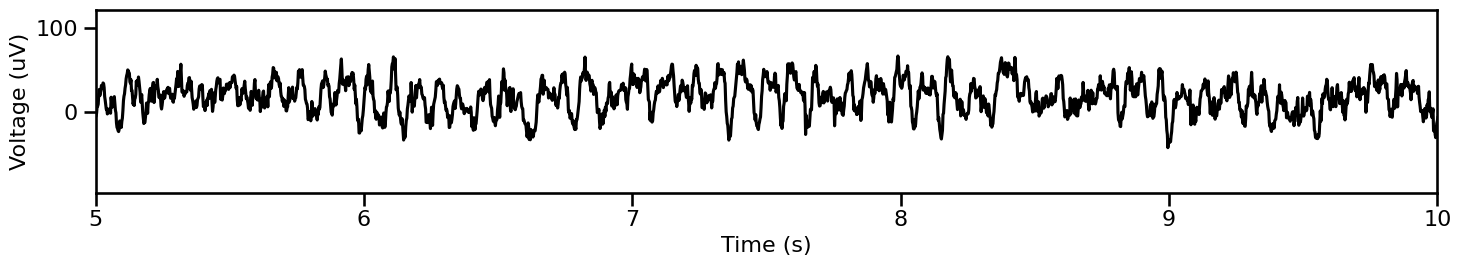

In [11]:
# Plot a segment of time series data
plot_time_series(times, data[0, :], xlim=[5, 10])

In [12]:
# Compute a power spectrum of an example
freqs, powers = compute_spectrum(data[0, :], fs, nperseg=2*fs, noverlap=fs)

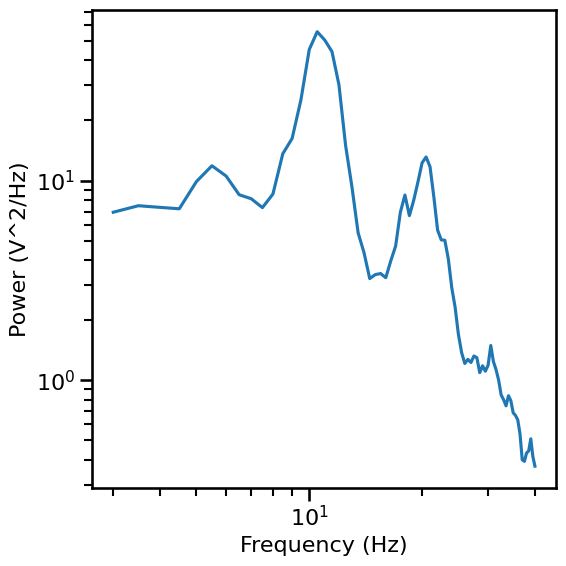

In [13]:
# Plot the power spectrum of the example data segment
plot_power_spectra(*trim_spectrum(freqs, powers, [3, 40]))

## Compare Methods

In [14]:
# General method settings
f_range = [3, 40]

In [15]:
# Initialize specparam model
fm = FOOOF(verbose=False)

In [16]:
# Define measures to apply
measures = {
    specparam : {'fs' : fs, 'f_range' : f_range},
    irasa : {'fs' : fs, 'f_range' : f_range},
    hurst : {'fs' : fs},
    dfa : {'fs' : fs},
    lempelziv : {},
    hjorth_complexity : {},
    app_entropy : {}
}

In [17]:
# Compute measures of interest on the data
outputs = run_measures(data, measures)

#### Compare Exponent Measures

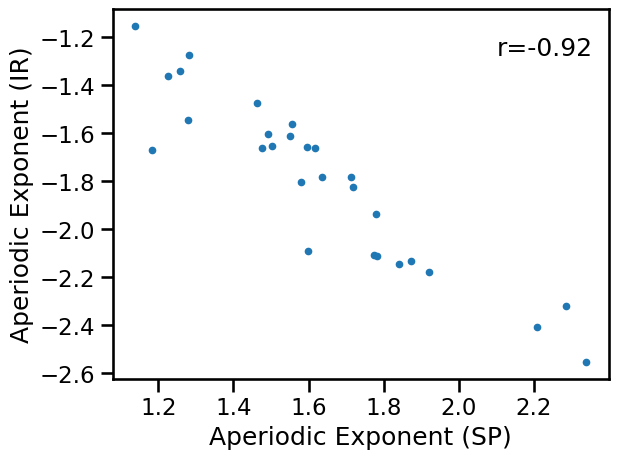

In [18]:
# Plot the comparison of specparam and IRASA exponent estimations
plot_dots(outputs['specparam'], outputs['irasa'],
          xlabel='Aperiodic Exponent (SP)', ylabel='Aperiodic Exponent (IR)')

In [19]:
# Check the correlation
sp_ir_corrs = bootstrap_corr(outputs['specparam'], outputs['irasa'])
print('  SP & IR:  ', format_corr(*sp_ir_corrs))

  SP & IR:   r=-0.920  CI[-0.980, -0.768],  p=0.000


#### Compare exponent to LZ Complexity

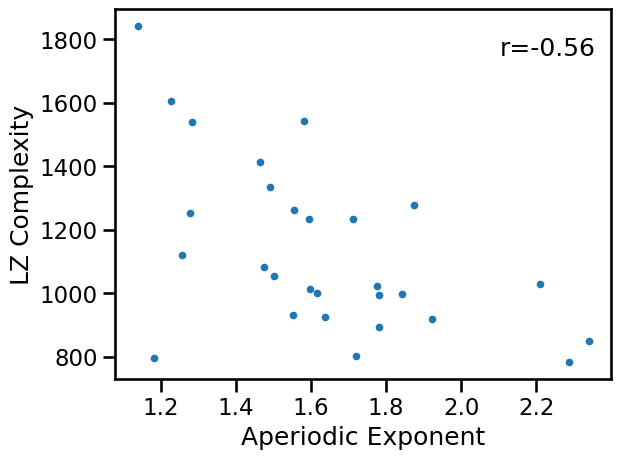

In [20]:
# Plot the comparison of specparam and lempel-ziv complexity
plot_dots(outputs['specparam'], outputs['lempelziv'],
          xlabel='Aperiodic Exponent', ylabel='LZ Complexity')

In [21]:
# Check the correlation
exp_lzc_corrs = bootstrap_corr(outputs['specparam'], outputs['lempelziv'])
print('  EXP & LZC:  ', format_corr(*sp_ir_corrs))

  EXP & LZC:   r=-0.920  CI[-0.980, -0.768],  p=0.000


#### Compare exponent to entropy

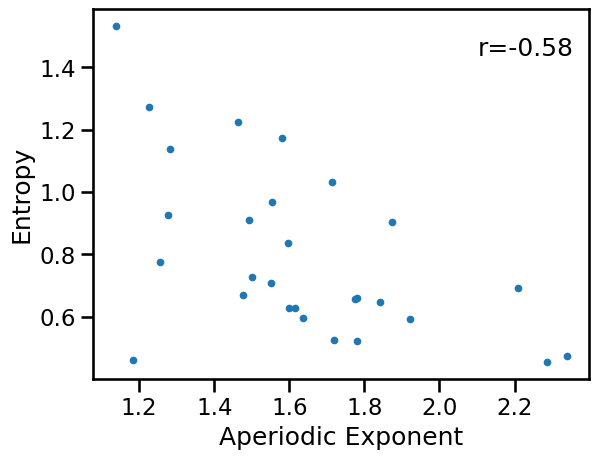

In [22]:
# Plot the comparison of specparam and approximate entropy
plot_dots(outputs['specparam'], outputs['app_entropy'],
          xlabel='Aperiodic Exponent', ylabel='Entropy')

In [23]:
# Check the correlation
exp_ent_corrs = bootstrap_corr(outputs['specparam'], outputs['app_entropy'],)
print('  EXP & ENT:  ', format_corr(*exp_ent_corrs))

  EXP & ENT:   r=-0.577  CI[-0.849, -0.187],  p=0.001


## Conclusions

Words, words, words.